In [5]:
from utils.utils import (
    lat_lon_to_epsg)
from datacube import Datacube
from ipywidgets import Button, Layout,HBox, VBox,Accordion,ToggleButtons,SelectionRangeSlider,Label
import json
import os
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from traitlets import link
import datetime
dc = Datacube()

center =[-20.0183,145.3134]
zoom = 10

def load_into_cube(measurements = None, cloud_mask = False):

    data = load_config('./configIndex.txt')
    #print (data)
    
   # product = data['product']
    
   # if product[0:3] == 's2a' or product[0:3] == 's2b':
        
    

    ds = dc.load(product=data['product'], 
                 measurements = ('red','green','blue','nir','swir1','swir2'),
                 group_by='solar_day',
                 y=tuple(data['lat']),
                 x=tuple(data['lon']),
                 time=tuple(data['time']),
                 output_crs=data['output_crs'],
                 resolution = (-10,10))

    
    return ds

def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def indexed_product():
    config = load_config('./configIndex.txt')
    ds = dc.find_datasets(product=config['product'],
                 latitude=tuple(config['lat']),
                 longitude=tuple(config['lon'])                 
                 )
    captured_dates = []
    for dataset in ds:
        captured_dates.append(dataset.time.begin.date())
    
    return sorted(captured_dates)
    
def indexed_product_time():
    config = load_config('./configIndex.txt')
    ds = dc.find_datasets(product=config['product'],
                 latitude=tuple(config['lat']),
                 longitude=tuple(config['lon']),
                 time=tuple(sorted(config['time']))
                 )
    captured_dates = []
    for dataset in ds:
        captured_dates.append(dataset.time.begin.date())
    
    return sorted(captured_dates)

    
    
def update_config(filename,variable,value):
    product = product_buttons.value
    with open(filename, 'r') as f:
        data = json.load(f)
        data[variable] = value
        
    os.remove(filename)
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

m = Map(center=center, zoom=zoom)
m2 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)

draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
draw_control2 = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})

def handle_draw(self, action, geo_json):
    if action == 'created':
        m2.add_layer(GeoJSON(data=draw_control.last_draw))
        draw_control2.last_draw =draw_control.last_draw
        
        lon_max = max([draw_control.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control.last_draw['geometry']['coordinates'][0][2][0]])
        lon_min = min([draw_control.last_draw['geometry']['coordinates'][0][0][0],
                       draw_control.last_draw['geometry']['coordinates'][0][2][0]])

        lat_max = max([draw_control.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control.last_draw['geometry']['coordinates'][0][2][1]])
        lat_min = min([draw_control.last_draw['geometry']['coordinates'][0][0][1],
                       draw_control.last_draw['geometry']['coordinates'][0][2][1]])
        EPSG = lat_lon_to_epsg(lat_max,lon_min)
        #lat = {'lat' : (lat_max,lat_min),
        #          'lon' : (lon_max,lon_min)}
        update_config('./configIndex.txt',
                 'output_crs',
                 'epsg:' + EPSG)
            
        update_config('./configIndex.txt',
                 'lat',
                 (lat_max,lat_min))

        update_config('./configIndex.txt',
                 'lon',
                 (lon_max,lon_min))

    if action == 'deleted':
        while len(m2.layers)>1:
            m2.remove_layer(m2.layers[1])

def handle_draw2(self, action, geo_json):
    
    if action == 'created':
        m.add_layer(GeoJSON(data=draw_control2.last_draw))
        draw_control.last_draw =draw_control2.last_draw
    if action == 'deleted':
        while len(m.layers)>1:
            m.remove_layer(m.layers[1])
            
#add handlers to draw controls  
draw_control.on_draw(handle_draw)
draw_control2.on_draw(handle_draw2)

#add draw controls to maps
m.add_control(draw_control)
m2.add_control(draw_control2)

#We can use link to synchronize traitlets of the two maps:

map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))

case_study_select = VBox([m,m2])


products_from_cube = dc.list_products()
product_list = list(dc.list_products()['name'].values)
product_description = list(dc.list_products()['description'].values)

product_buttons = ToggleButtons(
                    options=product_list,
                    description='Product:',
                    disabled=False,
                    button_style='', 
                    tooltips=product_description,
                    )
indexed_label = Label(value= "Number of indexed datasets for set location:   Number of epochs: ")


def product_func(change):
    update_config('./configIndex.txt',
                  'product',
                  product_buttons.value)
    captured_dates = indexed_product()
    
    indexed_label.value = "Number of indexed datasets for set location: " + str(len(captured_dates)) + ' Number of epochs: ' + str(len(set(captured_dates)))
    if captured_dates:
        date_range.options = captured_dates
    

#product_buttons.on_click(product_func)


product_buttons.observe(product_func, names = 'value')



dates = [datetime.date(2015,1,1) + datetime.timedelta(days =i) for i in range(1,2000)]
date_range = SelectionRangeSlider(options=dates,
                                          description = 'Date Range',
                                          disabled=False,
                                          layout = Layout(width='100%',height = '100px'))

def date_load(b):
    captured_dates = indexed_product()
    date_range.options = captured_dates



date_range.on_displayed(date_load)                                          

def date_func(b):
    start_date,end_date = date_range.value
    update_config('./configIndex.txt',
                  'time',
                  (start_date.strftime("%Y-%m-%d"),
                   end_date.strftime("%Y-%m-%d")))
    captured_dates = indexed_product_time()

    indexed_label.value = "Number of indexed datasets for set location: " + str(len(captured_dates)) + ' Number of epochs: ' + str(len(set(captured_dates)))

        
date_range.observe(date_func, names = 'value')

product_page = VBox([product_buttons,indexed_label, date_range])


accordion = Accordion(children=[case_study_select,product_page])
accordion.set_title(0, 'Select Case Study')
accordion.set_title(1, 'Select Satellite Product and Date range')
accordion

Accordion(children=(VBox(children=(Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', '…

In [2]:
%macro load_data_cube 1

Macro `load_data_cube` created. To execute, type its name (without quotes).
=== Macro contents: ===
from utils.utils import (
    lat_lon_to_epsg)
from datacube import Datacube
from ipywidgets import Button, Layout,HBox, VBox,Accordion,ToggleButtons,SelectionRangeSlider,Label
import json
import os
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)
from traitlets import link
import datetime
dc = Datacube()

center =[-20.0183,145.3134]
zoom = 10

def load_into_cube(measurements = None, cloud_mask = False):

    data = load_config('./configIndex.txt')
    #print (data)
    
   # product = data['product']
    
   # if product[0:3] == 's2a' or product[0:3] == 's2b':
        
    

    ds = dc.load(product=data['product'], 
                 measurements = ('red','green','blue','nir','swir1','swir2'),
                 group_by='solar_day',
                 y=tuple(data[

In [3]:
%store load_data_cube

Stored 'load_data_cube' (Macro)


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Rectangle', 'Circle', 'Button', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The formula we are using is (nir - red)/(nir + red)


<IPython.core.display.Javascript object>


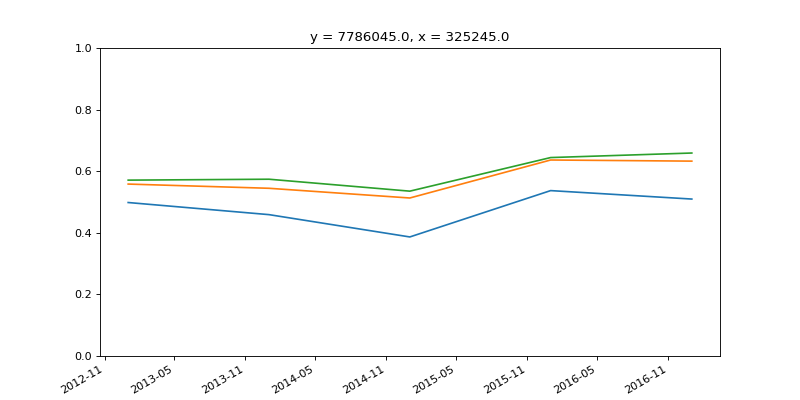

In [1]:
%pylab notebook
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

indicesa = ['NDVI','GNDVI','NDWI', 'NDMI']
indices_description = ['Normalised Difference Vegetation Index',
                      'Green Normalised Difference Vegetation Index',
                      'Normalised Difference Water Index',
                       'Normalised Difference Moisture Index']

target_dataset = target_dataset = BandIndices.calculate_indices(ds,'NDVI')

indices_buttons = ToggleButtons(
                    options=indicesa,
                    description='Product:',
                    disabled=False,
                    button_style='', 
                    tooltips=indices_description,
                    )

def indices_func(change):
    global target_dataset
    target_dataset = BandIndices.calculate_indices(ds,indices_buttons.value)

indices_buttons.observe(indices_func, names = 'value')


            
##Define output widget to display table
out = widgets.Output(layout={'border': '1px solid black'})

dataP = load_config('./configIndex.txt')

EPSG = int(dataP['output_crs'].split(':')[1])

m3 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)
draw_control3 = DrawControl(polygon = {"shapeOptions": {"fillOpacity": 0}})

infoLast = draw_control.last_draw
if infoLast:
    ds = load_into_cube()
    m3.add_layer(GeoJSON(data=infoLast))
else:
    print 'No Case Study Selected'


##---
def transform_from_wgs(getLong, getLat, EPSGa):
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)

    target = osr.SpatialReference()
    target.ImportFromEPSG(EPSGa)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt("POINT (" + str(getLong) + " " + str(getLat) + ")")
    point.Transform(transform)
    return [point.GetX(), point.GetY()]

##--

def transform_from_wgs_poly(geo_json,EPSGa):

    polygon = ogr.CreateGeometryFromJson(str(geo_json))

    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)

    target = osr.SpatialReference()
    target.ImportFromEPSG(EPSGa)

    transform = osr.CoordinateTransformation(source, target)
    polygon.Transform(transform)

    return eval(polygon.ExportToJson())


def plot_nDVI(self, action, geo_json):
    global output_pandas
    global datasetID

    plt.figure(0,[10,5])
    plt.ylim(0, 1)

    #print (geo_json)
    if geo_json['geometry']['type'] == 'Point':

        pixel_drill_long,pixel_drill_lat = geo_json['geometry']['coordinates']

        pixel_drill_x, pixel_drill_y = transform_from_wgs(pixel_drill_long,pixel_drill_lat,EPSG)
        drill_cube = target_dataset.sel(x=[pixel_drill_x,pixel_drill_x + 25], y=[pixel_drill_y, pixel_drill_y + 25],
                     method = 'nearest')
        
        time = np.ravel(drill_cube.isel(x=[0],y=[0]).time)
        values = np.ravel(drill_cube.isel(x=[0],y=[0]).values)
              
        drill_cube.isel(x=[0],y=[0]).plot()
        label = 'Point ' + str(datasetID)
        geo_json['properties']['datasetID'] = datasetID
        datasetID = datasetID + 1
        
    if geo_json['geometry']['type'] == 'Polygon':
        
        geom = transform_from_wgs_poly(geo_json['geometry'],EPSG)
        
        mask = rasterio.features.geometry_mask([geom for geoms in [geom]],
                                                   out_shape=ds.geobox.shape,
                                                   transform=ds.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        dataMasked = target_dataset.where(mask)
        data_masked_mean = dataMasked.mean(dim = ['x','y'])
        data_masked_mean.plot()
                
        time = np.ravel(data_masked_mean.time)
        values = np.ravel(data_masked_mean.values)
        
        label = 'Polygon ' + str(datasetID)
        geo_json['properties']['datasetID'] = datasetID

        datasetID = datasetID + 1
    
    geoJSONs.append(geo_json)

    output_pandas = pd.concat([output_pandas,pd.DataFrame(values,index = time, columns = [label])],axis = 1)
    out.clear_output()
    with out:
         print(output_pandas)

draw_control3.on_draw(plot_nDVI)
m3.add_control(draw_control3)

pixel_drill = VBox([indices_buttons,m3,out])

pixel_drill



In [5]:
%macro explore_area 4

Macro `explore_area` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('pylab', 'notebook')
import sys
import os
import osr 
import ogr
import ipywidgets as widgets
import pandas as pd
import rasterio.features
#sys.path.append(os.path.expanduser('dea-notebooks/Scripts'))
from utils import BandIndices

ds = load_into_cube()

global output_pandas
output_pandas= pd.DataFrame() 

global geoJSONs
geoJSONs = []

global datasetID
datasetID = 0

###Load EPSG
def load_config(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

indicesa = ['NDVI','GNDVI','NDWI', 'NDMI']
indices_description = ['Normalised Difference Vegetation Index',
                      'Green Normalised Difference Vegetation Index',
                      'Normalised Difference Water Index',
                       'Normalised Difference Moisture Index']

target_dataset = target_dataset = BandIndices.calculate_indices(ds,'NDVI')

indic

In [6]:
%store explore_area

Stored 'explore_area' (Macro)


In [3]:
! dir

 Volume in drive C is Windows
 Volume Serial Number is 6057-16EE

 Directory of C:\Repo\datacube-sandbox-notebooks

20/07/2018  04:33 PM    <DIR>          .
20/07/2018  04:33 PM    <DIR>          ..
20/07/2018  04:31 PM    <DIR>          .ipynb_checkpoints
20/07/2018  04:26 PM               323 configIndex.txt
20/07/2018  04:26 PM           171,241 Demo Macros.ipynb
20/07/2018  04:26 PM            11,558 LICENSE
20/07/2018  04:33 PM            35,961 Macros_Load.ipynb
20/07/2018  04:26 PM               104 README.md
20/07/2018  04:26 PM    <DIR>          utils
               5 File(s)        219,187 bytes
               4 Dir(s)  76,116,905,984 bytes free
